## DATA EXTRACTION

STEP1
- Code to extract and save movie-wise shen-parcellated fMRI data
- Each timecourse consists of the stimulus block (20s or 28images), the response screen (3s or 4images) and a part (7s or 10images) of the total fixation window (15s)


In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

fmri_dir = "/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha"
os.chdir(fmri_dir)
print('\nchanged current directory to:\n', fmri_dir)

folderName = os.path.join(fmri_dir,'indiv_data')
n = len(os.listdir(folderName))
print("\nnumber of folders=",n)
subj_folders = [i for i in os.listdir(folderName)]
print('subject folders',subj_folders[:10]) #beh data n=1051

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code

changed current directory to:
 /Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha

number of folders= 1114
subject folders ['239136', '531940', '103414', '339847', '115320', '173132', '148941', '212318', '990366', '206727']


In [2]:
print(os.getcwd())

/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha


In [3]:
#read in the shen-parcellated timecourses for all subjects and all nodes (subj*timecourseperrun*node)
f_RL = h5py.File("shen268_timecourses_RL.hdf5", "r") 
f_LR = h5py.File("shen268_timecourses_LR.hdf5", "r")

f_RL.keys()= <KeysViewHDF5 ['shen268_timecourses', 'subjlist']> 

type(d)= <class 'h5py._hl.dataset.Dataset'>
d.shape= (1053, 274, 268)
d.dtype= float64
d= <HDF5 dataset "shen268_timecourses": shape (1053, 274, 268), type "<f8"> 

type(d_RL): <class 'numpy.ndarray'>
d_RL.shape (1053, 274, 268)
d_RL.shape (1053, 274, 268)


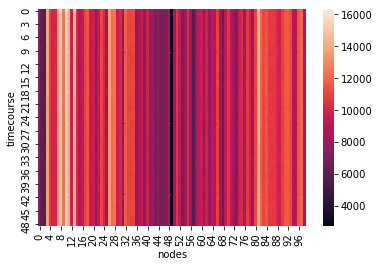

In [4]:
#playing around with this datatype
type(f_RL)
print('f_RL.keys()=',f_RL.keys(), '\n') # h5py.File() acts like a dictionary

# Exploring the datatype
d = f_RL['shen268_timecourses'] 
print('type(d)=', type(d))# d is of type Dataset. Like NumPy arrays, datasets have both a shape and a data type.
print('d.shape=',d.shape) # subjects, scan volumes, nodes
print('d.dtype=',d.dtype)
print('d=',d, "\n")

d_RL = np.array(f_RL['shen268_timecourses']) # extracting timecourses and converting them to arrays
print('type(d_RL):',type(d_RL))
print('d_RL.shape',d_RL.shape)
#plt.matshow(d_RL[0,1:50,1:100]) # time vs. nodes
sns.heatmap(d_RL[0,1:50,1:100]) # plot a few timepts and nodes to get an idea
plt.xlabel("nodes")
plt.ylabel("timecourse")
print('d_RL.shape',d_RL.shape)

Looks like timecourses are more similar across time within a node than across nodes - make sense - it could reflect firing props of neurons within that node or anything else typical of an roi

Now let's get working on the dataset. First we extract the data per run

In [5]:
#extract fMRI data and subject names
dat = {}
dat["run1"] = np.array(f_RL['shen268_timecourses'])
dat["run2"] = np.array(f_LR['shen268_timecourses'])

subj_list = {}
subj_list["run1"] = [x.decode('utf8') for x in list(f_RL['subjlist'])] #RL--> order of subjects for run 1
subj_list["run2"] = [x.decode('utf8') for x in list(f_LR['subjlist'])] #LR

In [6]:
#names of videos per run (always presented the same across subjects)
vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]#RL
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]#LR
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_cat = {}
vid_cat["run1"] = [1,0,0,1,0] # 1:mental,0: random
vid_cat["run2"] = [1,1,0,1,0]

In [7]:
# info needed to make a  regressor
vid_onsets_in_sec = [8, 46, 84, 122, 160]
tr = 0.72
#l = 34 # duration
duration_secs = 20
l_task = int(np.round(duration_secs/tr))  # duration measured in nr of images = 28 for 20s
print('Duration of task block:', l_task)
print('Nr of fixation images:', np.round(15/tr))
l_fix_start = 0
l_fix_end = int(l_task/2)
print('setting baseline images at:',l_fix_end) # since there's fixation pre and post task block
l_resp_screen = int(np.round(3/tr))
print("Duration of resp screen:", l_resp_screen)

Duration of task block: 28
Nr of fixation images: 21.0
setting baseline images at: 14
Duration of resp screen: 4


In [8]:
#exploring the timecourse
vid_onsets_imagenr = np.zeros_like(vid_onsets_in_sec)
for i in range(5):
    vid_onsets_imagenr[i] = np.floor((vid_onsets_in_sec[i]/tr)-1) # seconds to image nr (-1 since indices start from 0)
print(vid_onsets_imagenr)
print(np.diff(vid_onsets_imagenr)) # sanity check: are the distances between onset images the same?

[ 10  62 115 168 221]
[52 53 53 53]


# Creating the regressor

Text(0.5, 0, 'Time')

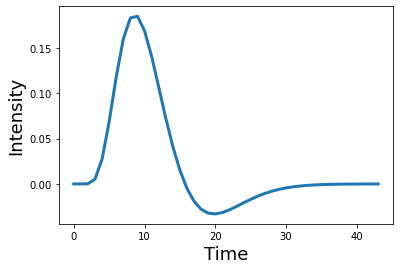

In [9]:
#defining the hrf
from nltools.external import glover_hrf

#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

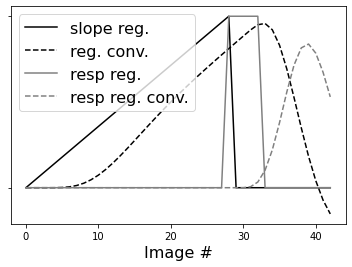

In [10]:
# Here we (1) store moviewise time windows, and, in this time window,
# (2) create movie_wise SLOPE regressors and (3) response regressors.

nmovies = 10
timepts_indiv_movie = [] # to store timepts (prestim fix if applicable + stim + poststim fix) for each movie
reg_all = [] # slope regressor per movie
reg_conv_all = [] # to store slope regressors for all movies
respreg_all = [] # to store response regressors for all movies
respreg_conv_all = [] # response window in block per movie

for vid_no in range(nmovies):
    run = "run1" if vid_no < 5 else "run2"
    vrun = vid_no%5
    vid = vid_names[run][vrun]
    #print(vid)
    
    vidonset_imnr = np.floor((vid_onsets_in_sec[vrun]/tr)-1) # converting video onset image
                                                             # nr from onset time in secs
    start_frame = int(vidonset_imnr) - l_fix_start # change l_fix_start to start the 
                                                   # regressor earlier
    end_frame = int(vidonset_imnr) + l_task + l_fix_end  # onset frame + length of video +
                                                         # (response screen+fixation time)
    # part 1
    timepts = np.arange(start_frame, end_frame+1) 
    timepts_indiv_movie.append(timepts)  # timepts (stim+ fix) for each movie
    
    # part 2
    vid_start = int(vidonset_imnr) 
    vid_start = vid_start - start_frame # 0 if same pt, >0 otherwise
    #print('vid_start',vid_start)
    vid_end = vid_start + l_task
    #print('vid_end',vid_end)
    reg = np.zeros((end_frame+1-start_frame))
    reg[vid_start:vid_end+1] = np.arange(0,l_task+1)/np.max(np.arange(0,l_task+1)) # normalised ascending slope regressor 
                                                            # during video, 0 before and after video
    reg_conv = np.convolve(reg, hrf) # convolve reg with HRF
    reg_conv = reg_conv[:len(reg)] # make convolved regressor same length as original regressor
    
    if vid_no == 0:
        plt.figure(figsize = (6,4))
        plt.plot(reg,      label = 'slope reg.', color = 'k')
        plt.plot(reg_conv, label = 'reg. conv.', color = 'k', ls = 'dashed')
        plt.xlabel('Image #', fontsize = 16)
        plt.yticks([0,1],['',''], fontsize = 16)
    reg_all.append(reg)
    reg_conv_all.append(reg_conv) # slope regressors for each movie
    
    # part 3
    resp_screen_start = vid_end # get the relevant frames by converting sec to tr
    resp_screen_end = resp_screen_start + l_resp_screen
    respreg = np.zeros((end_frame+1-start_frame))
    respreg[resp_screen_start:resp_screen_end+1] = 1
    respreg_conv = np.convolve(respreg, hrf)
    respreg_conv = respreg_conv[:len(respreg)]
    if vid_no == 0:
        plt.plot(respreg, label = 'resp reg.', color = 'gray')
        plt.plot(respreg_conv,    label = 'resp reg. conv.', color = 'grey', ls = 'dashed')
        plt.legend(loc = 'best', fontsize = 16)
        #plt.xlabel('Image #', fontsize = 16)
        #plt.yticks([0,1],['',''], fontsize = 16)
    respreg_all.append(respreg)
    respreg_conv_all.append(respreg_conv) # block response regressors for each movie



In [11]:
os.getcwd()

'/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha'

In [12]:
#save regressor variables

import pickle
os.chdir(data_file_loc)
pickle.dump([timepts_indiv_movie, reg_all, reg_conv_all, respreg_all, respreg_conv_all],
            open("movie_wise_regs_windows.p", "wb")) # saving regressor vaeriables

timepts_indiv_movie, reg_all, reg_conv_all, respreg_all, respreg_conv_all = 
            pickle.load(open("movie_wise_regs_windows.p","rb")) # to verify the saved variables

SyntaxError: invalid syntax (<ipython-input-12-a8b10118035d>, line 8)

In [21]:
#extract behavioral data, remove impossibly quick responses

beh_data = pd.read_csv("/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha/hcp_social_behav_for_ddm_stim-coding.csv")
rtmin = 0.1 # threshold for impossibly short RTs

print('nrows before=', beh_data.shape)
print("total subjects before=",len(np.unique(beh_data['subj_idx'])))
beh_data_old = beh_data
beh_data= beh_data[beh_data["rt"]>=rtmin]
print('\nnrows after=', beh_data.shape)
print("total subjects after=",len(np.unique(beh_data['subj_idx'])))
#print(np.where(beh_data.index == subj_shortRT[0]))

nrows before= (10149, 5)
total subjects before= 1051

nrows after= (9950, 5)
total subjects after= 1050


In [26]:
len(np.where(beh_data_old['movie'] == 'Random mechanical.AVI')[0])

873

In [25]:
len(np.where(beh_data_old['movie'] == 'Fishing.AVI')[0])

1018

In [68]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this
    function shows what the output really means. This function skips NaNs, and
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but
    this can be changed to be a max/min/median or other function that returns a
    single numeric value based on a sequence of values.
    """

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],
                                             window=window,
                                             FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(1 - window), 1):

            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue

            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]

        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output

In [69]:
def preproc(Y):
    # function to normalise timecourses and baseline correct them
    Y = my_moving_window(Y)
    Y = Y - np.min(Y)
    Y = Y/np.max(Y)
    Y = Y - Y[0]
    return Y,Y[0]

In [71]:
os.chdir(data_file_loc)
os.getcwd()

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Finished video 0 , elapsed time: 153.57377934455872
['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Finished video 1 , elapsed time: 311.26968717575073
['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
Finished video 2 , elapsed time: 788.555064201355
['only one subject for ind ', 438, ', subjID:', '175540']
['only one subject for ind ', 453, ', subjID:', '748662']
['only one subject for ind ', 710,

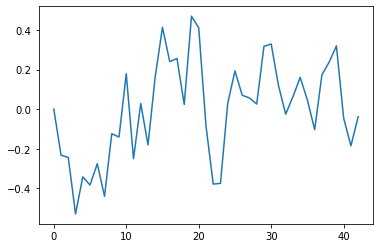

In [78]:
# takes 30mins to run, watch out!
# preprocess Y, store (1) moviewise timecourses, (2) baseline normY and beh responses across movies
# save preprocessed timecourses for each movie in 10 files (each file about 96MB)
nsubj = 1053 #1053
nmovies = 10#10
nnodes = 268 #268
start = time.time()

y0 = np.zeros((nsubj,nmovies,nnodes))
responses = np.zeros((nsubj,nmovies))-1 # initialise responses with -1
    
for vid_no in np.arange(0,nmovies):
    run = 'run1' if vid_no < 5 else 'run2'
    vidName = vid_names[run][vid_no%5]
    vidName = '.'.join((vidName,'AVI')) # add .avi
         
    ntimepts  = len(timepts_indiv_movie[vid_no])
    Ynorm = np.zeros((nsubj, nnodes, ntimepts))

    sub_ind = -1
    for s1 in np.arange(0,nsubj):
        now = time.time()
        #print('subj:',s1,', time elapsed:', (now - start))
        curr_subj = subj_list['run1'][s1]
        try:
            s2 = subj_list['run2'].index(curr_subj) 
                # see if the subject has data for run 2, if not don't count them
            
            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
            if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                responses[sub_ind,vid_no] = beh_data.loc[row,'response']

            for node in range(nnodes):
                rows = timepts_indiv_movie[vid_no] # rows within run for that video
                if run == 'run1':
                    Y = dat[run][s1,rows,node] 
                elif run == 'run2':
                    Y = dat[run][s2,rows,node]
                
                Ynorm[sub_ind,node,:],y0[sub_ind,vid_no,node] = preproc(Y) # baseline correction and normalisation
                if (vid_no == 0) and (s1 == 0) and (node==0):
                    plt.plot(Ynorm[sub_ind,node,:])
        except:
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

    Ynorm = Ynorm[:sub_ind+1,:,:]
    now = time.time()
    np.save(f'timecourse-movie{vid_no}', Ynorm)
    print('Finished video', vid_no, ', elapsed time:', now-start)

responses = responses[:sub_ind+1,:]
y0 = responses[:sub_ind+1,:]
np.save('beh_responses', responses)
np.save('ybsln_slopereg', y0)

In [79]:
1919/60

31.983333333333334